In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib  # To save models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# Load dataset
file_path = "startup_growth_investment_data.csv"  # Ensure the file is in the same directory
df = pd.read_csv(file_path)

# Apply log transformation to valuation
df["Valuation (USD)"] = np.log1p(df["Valuation (USD)"])

# One-Hot Encode Categorical Features
df = pd.get_dummies(df, columns=["Industry", "Country"], drop_first=True)

# Scale numerical features
features_to_scale = ["Investment Amount (USD)", "Funding Rounds", "Number of Investors", "Growth Rate (%)"]
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Split data into training and test sets
X = df.drop(columns=["Startup Name", "Valuation (USD)"])  # Drop non-useful columns
y = df["Valuation (USD)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "k-NN": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "SVM": SVR(kernel="rbf"),
    "ANN (MLP)": MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
}

# Train and evaluate models using 10-fold cross-validation
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring="neg_root_mean_squared_error")
    avg_rmse = -scores.mean()  # Convert negative RMSE back to positive
    
    # Save model
    joblib.dump(model, f"{name.replace(' ', '_')}.pkl")
    
    results[name] = {"RMSE (10-fold CV)": avg_rmse}

# Print results
print("\nModel Performance (10-fold Cross-Validation RMSE):")
for name, metrics in results.items():
    print(f"{name}: RMSE = {metrics['RMSE (10-fold CV)']:.2f}")



Model Performance (10-fold Cross-Validation RMSE):
Linear Regression: RMSE = 0.60
k-NN: RMSE = 0.65
Decision Tree: RMSE = 0.48
SVM: RMSE = 1.07
ANN (MLP): RMSE = 0.66
Random Forest: RMSE = 0.35


In [3]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define hyperparameter grid for Random Forest
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

# Initialize Random Forest model
rf = RandomForestRegressor(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_grid, 
    n_iter=20, cv=5, scoring="neg_root_mean_squared_error", 
    random_state=42, n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters and performance
best_rf = random_search.best_estimator_
best_params = random_search.best_params_
best_rmse = -random_search.best_score_

# Print results
print(f"Best Parameters: {best_params}")
print(f"Best RMSE (Cross-Validation): {best_rmse:.2f}")


Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': True}
Best RMSE (Cross-Validation): 0.35


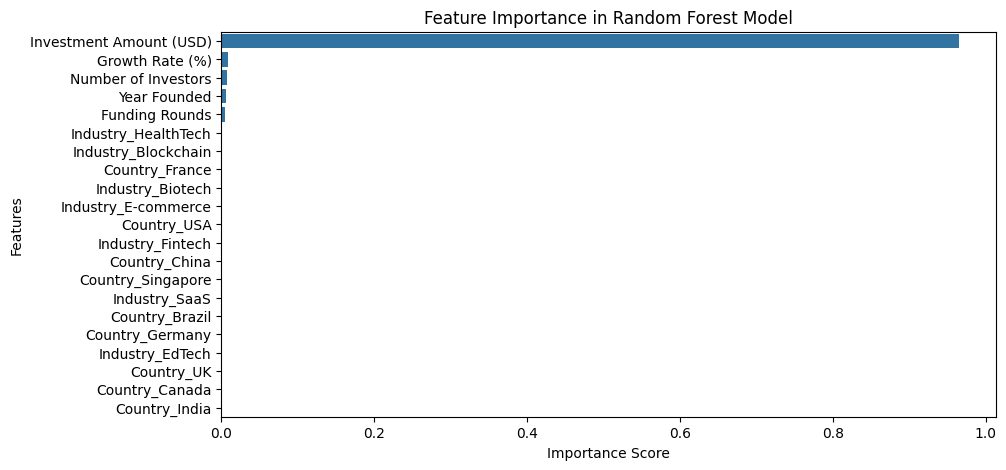

Top Features:
                     Feature  Importance
1   Investment Amount (USD)    0.965796
4           Growth Rate (%)    0.009280
2       Number of Investors    0.007512
3              Year Founded    0.006428
0            Funding Rounds    0.004053
10      Industry_HealthTech    0.000994
6       Industry_Blockchain    0.000526
15           Country_France    0.000487
5          Industry_Biotech    0.000465
7       Industry_E-commerce    0.000445


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from the best Random Forest model
feature_importance = best_rf.feature_importances_

# Create a DataFrame
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"])
plt.title("Feature Importance in Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Print top features
print("Top Features:\n", importance_df.head(10))


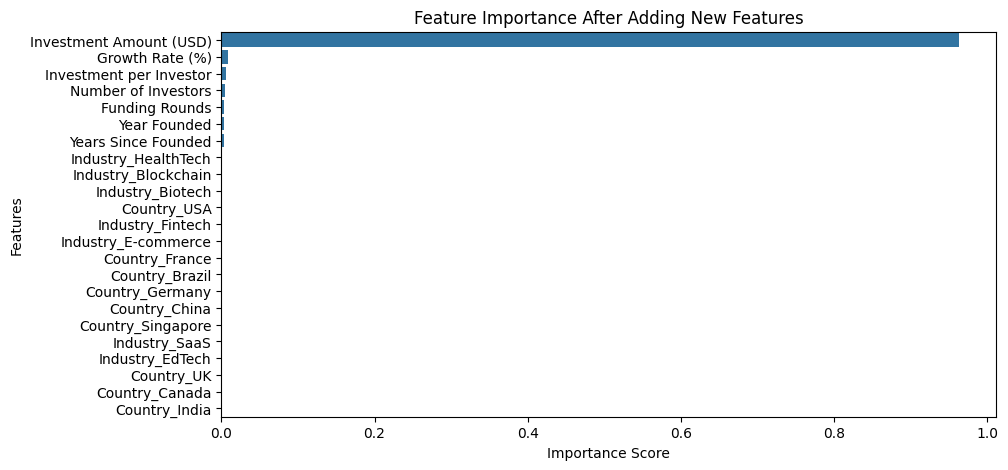

Top Features:
                     Feature  Importance
1   Investment Amount (USD)    0.963992
4           Growth Rate (%)    0.008437
21  Investment per Investor    0.006565
2       Number of Investors    0.005285
0            Funding Rounds    0.003676
3              Year Founded    0.002974
22      Years Since Founded    0.002894
10      Industry_HealthTech    0.000920
6       Industry_Blockchain    0.000525
5          Industry_Biotech    0.000405


In [5]:
# Create new features
df["Investment per Investor"] = df["Investment Amount (USD)"] / (df["Number of Investors"] + 1)  # Avoid division by zero
df["Years Since Founded"] = 2025 - df["Year Founded"]

# Reapply feature scaling
features_to_scale = ["Investment Amount (USD)", "Funding Rounds", "Number of Investors", 
                     "Growth Rate (%)", "Investment per Investor", "Years Since Founded"]

scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Split the data again
X = df.drop(columns=["Startup Name", "Valuation (USD)"])
y = df["Valuation (USD)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Retrain Random Forest with the best parameters found
best_rf = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=4, 
                                max_depth=10, bootstrap=True, random_state=42)

best_rf.fit(X_train, y_train)

# Get new feature importance
feature_importance = best_rf.feature_importances_

# Create DataFrame for feature importance
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"])
plt.title("Feature Importance After Adding New Features")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Print top features
print("Top Features:\n", importance_df.head(10))


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the test set
y_pred = best_rf.predict(X_test)

# Calculate final evaluation metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Final Model Evaluation on Test Set:")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAE: {mae:.2f}")
print(f"  R² Score: {r2:.4f}")


Final Model Evaluation on Test Set:
  RMSE: 0.35
  MAE: 0.29
  R² Score: 0.8849


c:\Users\Pol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [7]:
from sklearn.feature_selection import RFE

# Define the base model for feature selection
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42)

# Use Recursive Feature Elimination (RFE)
rfe = RFE(estimator=rf_selector, n_features_to_select=10)  # Keep top 10 features
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# Train new model with only selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

rf_selected = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=4, 
                                    max_depth=10, bootstrap=True, random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Evaluate the new model
y_pred_selected = rf_selected.predict(X_test_selected)

rmse_selected = mean_squared_error(y_test, y_pred_selected, squared=False)
mae_selected = mean_absolute_error(y_test, y_pred_selected)
r2_selected = r2_score(y_test, y_pred_selected)

# Print new results
print("\nModel with Selected Features:")
print(f"  RMSE: {rmse_selected:.2f}")
print(f"  MAE: {mae_selected:.2f}")
print(f"  R² Score: {r2_selected:.4f}")


Selected Features: Index(['Funding Rounds', 'Investment Amount (USD)', 'Number of Investors',
       'Year Founded', 'Growth Rate (%)', 'Industry_Blockchain',
       'Industry_Fintech', 'Industry_HealthTech', 'Investment per Investor',
       'Years Since Founded'],
      dtype='object')

Model with Selected Features:
  RMSE: 0.35
  MAE: 0.29
  R² Score: 0.8838


c:\Users\Pol\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
from xgboost import XGBRegressor

# Train an XGBoost model
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost R² Score: {r2_xgb:.4f}")
